# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
from model import load_data, get_analytics
from cytoself_custom import plot_umap, calc_umap_embvec, plot_feature_spectrum_from_image, arrange_plots
from synthetic_multiplexing import multiplex
from metrics import plot_boostrapping, calc_bootstrapping, plot_metrics, calc_reconstruction_error
from explainability import generate_images, plot_clusters_distance_heatmap
from utils import get_colors_dict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
import seaborn as sns

from tensorflow.compat.v1.keras.models import Model


import os
import config
from config import SEED, PRETRAINED_MODEL_PATH, MODEL_FOLDER, METRICS_FOLDER, METRICS_MATCH_PATH, METRICS_RANDOM_PATH, MARKERS,MICROGLIA_MARKERS

np.random.seed(SEED)
random.seed(SEED)

%reload_ext autoreload
%autoreload 2
%aimport

In /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/labs/hornsteinlab/noamru/anaconda3/envs/cytoself4/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was dep

Modules to reload:
all-except-skipped

Modules to skip:



# Logs

In [3]:
import logging
# log_file_path = f"./logs/fc_outputs_log.log"
# logging.basicConfig(level=logging.INFO,
#                     format="%(asctime)s %(levelname)s %(message)s",
#                     datefmt="%Y-%m-%d %H:%M:%S",
#                     handlers=[
#         logging.FileHandler(log_file_path),
#         logging.StreamHandler()
#     ])

logging.info("init")

2023-01-02 17:40:14 INFO init


## Config

In [4]:
logging.info(f"Set config")

COMBINED_MODEL_PATH = "/home/labs/hornsteinlab/Collaboration/MOmaps/model_outputs/comb_model_trying/model_ep0047_combined_default.h5"
IMGSELF_MODEL_PATH = "./models/microglia_model.h5"
NEUROSELF_MODEL_PATH = os.path.join(MODEL_FOLDER, "MODEL18_model_weights.0040.h5")

input_folders_imgself =["./data/processed/microglia"]
input_folders_neuroself =["./data/processed/220814_neurons","./data/processed/220818_neurons",
                          "./data/processed/220831_neurons","./data/processed/220908","./data/processed/220914"]
input_folders_combined = input_folders_imgself + input_folders_neuroself

cytoself_model_path = PRETRAINED_MODEL_PATH

markers_for_load=["G3BP1","KIF5A","TIA1","NONO","SQSTM1","FMRP","CD41","PSD95","CLTC","Phalloidin","phalloidin","NEMO",
                  "DCP1A","GM130","TOMM20","Nucleolin","NCL","SCNA","SNCA","ANXA11","LAMP1","Calreticulin",
                  "PML","PEX14","DAPI","FUS","IL18RAP","pNFKB","mitotracker","PURA","TDP43"] #removed syto12, lysotracker, pura and tdp43

markers_for_load_comb = ["G3BP1","KIF5A","TIA1","NONO","SQSTM1","FMRP","CD41","PSD95","CLTC","Phalloidin","phalloidin","NEMO",
                  "DCP1A","GM130","TOMM20","Nucleolin","NCL","SCNA","SNCA","ANXA11","LAMP1","Calreticulin",
                  "PML","PEX14","DAPI","FUS"]

2023-01-02 17:40:14 INFO Set config


## Load Data

In [28]:
# logging.info(f"Loading data imgself")
# images_imgself, labels_imgself, _, _ = load_data(input_folders_imgself, condition_l=False, type_l=False,cell_type_l=False,
#                                                                cell_lines_include=["WT"], 
#                                                                split_by_set=True,
#                                                                set_type="test",
#                                                                markers=markers_for_load+["syto12"],
#                                                                conds_include=['unstressed'])

# logging.info(f"Labels: {np.unique(labels_imgself)}")
# labels_unique_imgself = np.unique(labels_imgself)

# logging.info(f"Loading data neuroself")
# images_neuroself, labels_neuroself, _, _ = load_data(input_folders_neuroself, condition_l=False, type_l=False,cell_type_l=False,
#                                                                cell_lines_include=["WT"], 
#                                                                split_by_set=True,
#                                                                set_type="test",
#                                                                markers=markers_for_load,
#                                                                conds_include=['unstressed'])

# logging.info(f"Labels: {np.unique(labels_neuroself)}")
# labels_unique_neuroself = np.unique(labels_neuroself)

logging.info(f"Loading data combined")
images_comb, labels_comb, _, _ = load_data(input_folders_combined, condition_l=False, type_l=False,cell_type_l=True,
                                                               cell_lines_include=["WT"], 
                                                               split_by_set=True,
                                                               set_type="test",
                                                               markers=markers_for_load_comb,
                                                               conds_include=['unstressed'])

logging.info(f"Labels: {np.unique(labels_comb)}")
labels_unique_combined = np.unique(labels_comb)


2023-01-02 17:54:58 INFO Loading data combined


#########################################################
########### Splitting by set! (test) #############
#########################################################
Input folder: ./data/processed/microglia
Input subfolder: ANXA11
Filepath: ./data/processed/microglia/WT/unstressed/ANXA11/221002_iNDI_MG_WT_unstressed-SCNA_ANXA11_DAPI_WT.tif_processed
Input subfolder: CD41
Filepath: ./data/processed/microglia/WT/unstressed/CD41/220929_iNDI_MG_WT_unstressed-SQSTM1_FMRP_CD41_DAPI_WT.tif_processed
Input subfolder: CLTC
Filepath: ./data/processed/microglia/WT/unstressed/CLTC/220930_iNDI_MG_WT_unstressed-PSD95_CLTC_phalloidin_DAPI_WT.tif_processed
Input subfolder: Calreticulin
Filepath: ./data/processed/microglia/WT/unstressed/Calreticulin/221003_iNDI_MG_WT_unstressed-LAMP1_Calreticulin_DAPI_WT.tif_processed
Input subfolder: DAPI
Filepath: ./data/processed/microglia/WT/unstressed/DAPI/2200908_iNDI_MG_WT_unstressed-G3BP1_KIF5A_TIA1_DAPI_WT.tif_processed
Filepath: ./data/processed/microglia/WT

Input subfolder: Calreticulin
Filepath: ./data/processed/220908/WT/unstressed/Calreticulin/220830_iNDI_WT_unstressed-DAPI_LAMP1_Calreticulin-_WT.tif_processed
Input subfolder: DAPI
Filepath: ./data/processed/220908/WT/unstressed/DAPI/220829_iNDI_WT_unstressed-DAPI_lysotracker_SNCA_ANXA11-_WT.tif_processed
Filepath: ./data/processed/220908/WT/unstressed/DAPI/220830_iNDI_WT_unstressed-DAPI_LAMP1_Calreticulin-_WT.tif_processed
Filepath: ./data/processed/220908/WT/unstressed/DAPI/220830_iNDI_WT_unstressed-DAPI_Nucleolin_FUS_mitotracker-_WT.tif_processed
Input subfolder: FUS
Filepath: ./data/processed/220908/WT/unstressed/FUS/220830_iNDI_WT_unstressed-DAPI_Nucleolin_FUS_mitotracker-_WT.tif_processed
Input subfolder: LAMP1
Filepath: ./data/processed/220908/WT/unstressed/LAMP1/220830_iNDI_WT_unstressed-DAPI_LAMP1_Calreticulin-_WT.tif_processed
Input subfolder: Nucleolin
Filepath: ./data/processed/220908/WT/unstressed/Nucleolin/220830_iNDI_WT_unstressed-DAPI_Nucleolin_FUS_mitotracker-_WT.tif_p

2023-01-02 17:55:05 INFO Labels: ['ANXA11_microglia' 'ANXA11_neurons' 'CD41_microglia' 'CD41_neurons'
 'CLTC_microglia' 'CLTC_neurons' 'Calreticulin_microglia'
 'Calreticulin_neurons' 'DAPI_microglia' 'DAPI_neurons' 'DCP1A_microglia'
 'DCP1A_neurons' 'FMRP_microglia' 'FMRP_neurons' 'FUS_microglia'
 'FUS_neurons' 'G3BP1_microglia' 'G3BP1_neurons' 'GM130_microglia'
 'GM130_neurons' 'KIF5A_microglia' 'KIF5A_neurons' 'LAMP1_microglia'
 'LAMP1_neurons' 'NCL_microglia' 'NEMO_microglia' 'NEMO_neurons'
 'NONO_microglia' 'NONO_neurons' 'Nucleolin_neurons' 'PEX14_microglia'
 'PEX14_neurons' 'PML_microglia' 'PML_neurons' 'PSD95_microglia'
 'PSD95_neurons' 'Phalloidin_neurons' 'SCNA_microglia' 'SNCA_neurons'
 'SQSTM1_microglia' 'SQSTM1_neurons' 'TIA1_microglia' 'TIA1_neurons'
 'TOMM20_microglia' 'TOMM20_neurons' 'phalloidin_microglia']


Input subfolder: Syto12
Skipping Syto12
(1123, 100, 100, 2) (1123, 1)


## Get Analytics

In [29]:
logging.info(f"Getting analytics...")
#analytics_imgself = get_analytics(images_imgself,labels_imgself, model_path=IMGSELF_MODEL_PATH)
#analytics_neuroself = get_analytics(images_neuroself,labels_neuroself, model_path=NEUROSELF_MODEL_PATH)
analytics_combined = get_analytics(images_comb,labels_comb, model_path=COMBINED_MODEL_PATH)


2023-01-02 17:55:07 INFO Getting analytics...


X, y:
(1123, 100, 100, 2) (1123,)
DAPI_neurons              240
DAPI_microglia            128
Phalloidin_neurons         37
Nucleolin_neurons          29
FUS_neurons                29
GM130_neurons              27
PML_neurons                24
PEX14_neurons              24
NONO_neurons               23
CD41_neurons               23
KIF5A_neurons              21
SNCA_neurons               21
LAMP1_neurons              21
Calreticulin_neurons       21
ANXA11_neurons             21
TIA1_neurons               21
PSD95_neurons              21
G3BP1_neurons              21
CLTC_neurons               21
NEMO_neurons               19
DCP1A_neurons              19
FMRP_neurons               18
SQSTM1_neurons             18
TOMM20_neurons             16
G3BP1_microglia            15
KIF5A_microglia            15
TIA1_microglia             15
GM130_microglia            14
TOMM20_microglia           14
LAMP1_microglia            13
SQSTM1_microglia           13
CD41_microglia             13
Calret

## Build model

In [6]:
logging.info(f"Build model...")
model_fc_imgself = Model(analytics_imgself.model.img_input, analytics_imgself.model.fc_outputs[::-1])
model_fc_neuroself = Model(analytics_neuroself.model.img_input, analytics_neuroself.model.fc_outputs[::-1])
model_fc_combined = Model(analytics_combined.model.img_input, analytics_combined.model.fc_outputs[::-1])


2023-01-01 15:10:14 INFO Build model...


## Predict

In [16]:
def predict(analytics,labels_unique, model_fc):
    ##### TAKE ALL!
    n_samples = len(analytics.data_manager.test_data)
    #####
    print(n_samples)
    indexes = np.random.choice(np.arange(len(analytics.data_manager.test_data)), n_samples, replace=False)
    print(indexes.shape)
    data = analytics.data_manager.test_data[indexes]
    labels = analytics.data_manager.test_label[indexes]
    #logging.info(f"{len(data)}, {len(labels)}, {indexes}")

    labels_true = labels.reshape(-1,)
    logging.info(f"Predict...")
    predictions = model_fc.predict(data, batch_size=min(n_samples, analytics.model.batch_size * 4))
    predictions = [labels_unique[np.argmax(p, 1)] for p in predictions]
    pred1, pred2 = predictions[0], predictions[1]
    
    return pred1,pred2,labels_true

2023-01-01 16:04:10 INFO Predict init...
2023-01-01 16:04:10 INFO Predict...
2023-01-01 16:04:11 INFO Predict...
2023-01-01 16:04:13 INFO Predict...


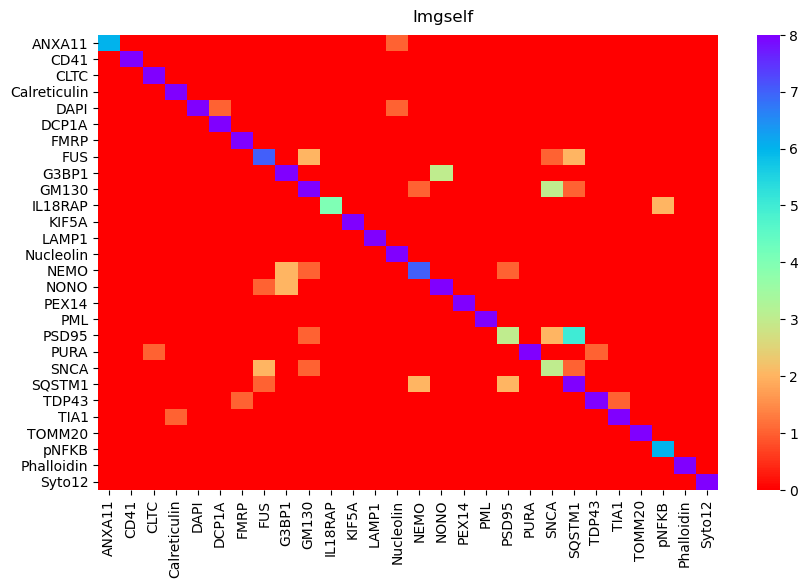

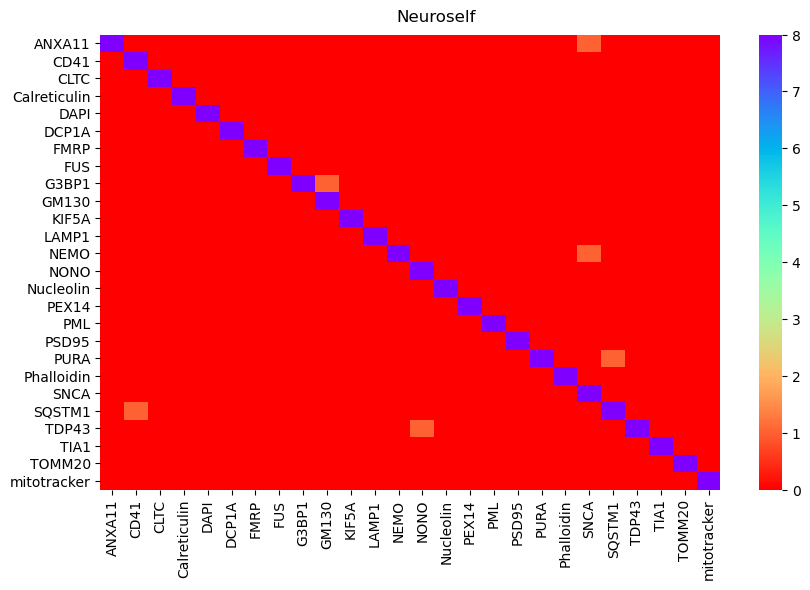

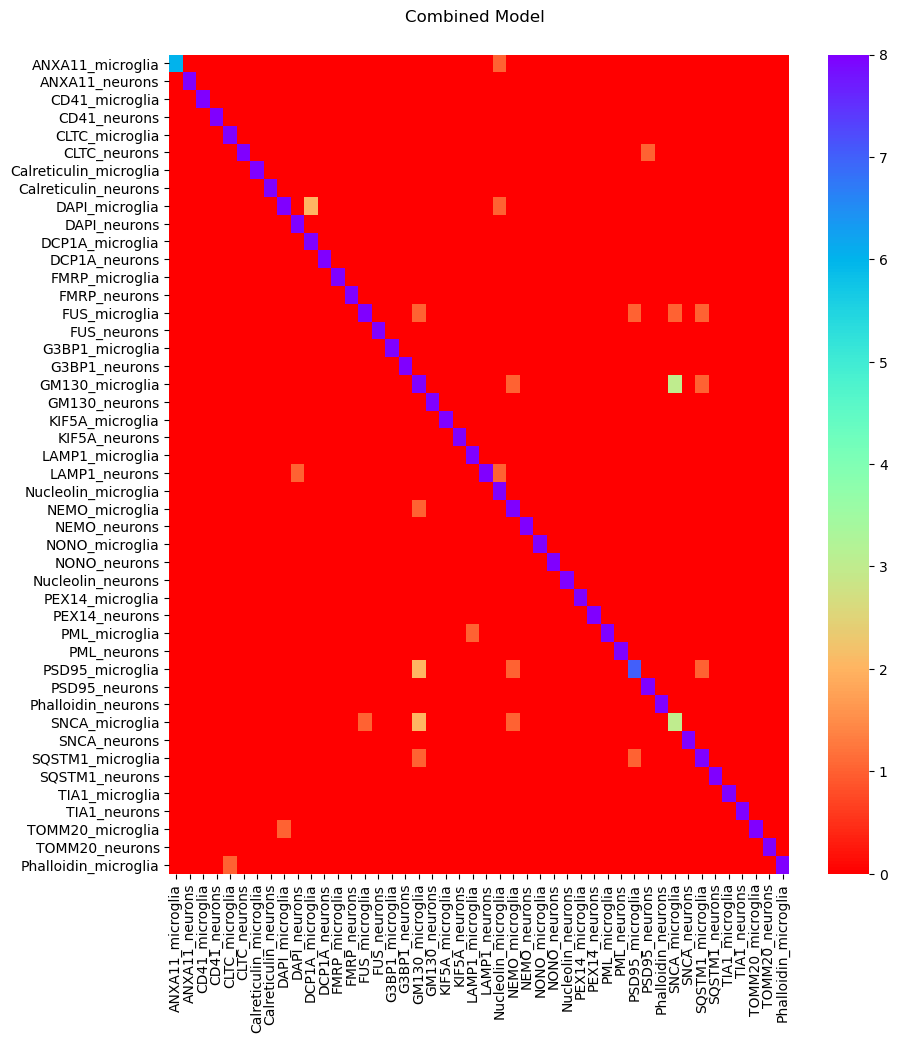

In [68]:
logging.info(f"Predict init...")

pred1_imgself, pred2_imgself, labels_true_imgself = predict(analytics_imgself, labels_unique_imgself,model_fc_imgself)
pred1_neuroself, pred2_neuroself, labels_true_neuroself = predict(analytics_neuroself, labels_unique_neuroself,model_fc_neuroself)
pred1_combined, pred2_combined, labels_true_combined = predict(analytics_combined, labels_unique_combined,model_fc_combined)
conf_imgself = metrics.confusion_matrix(labels_true_imgself,pred2_imgself,labels=labels_unique_imgself)
standard_labels_imgself = np.array(["ANXA11","CD41","CLTC","Calreticulin","DAPI","DCP1A","FMRP",
                                    "FUS","G3BP1","GM130","IL18RAP","KIF5A","LAMP1","Nucleolin",
                                    "NEMO","NONO","PEX14","PML","PSD95","PURA","SNCA","SQSTM1","TDP43",
                                    "TIA1","TOMM20","pNFKB","Phalloidin","Syto12"])
conf_imgself = pd.DataFrame(conf_imgself, columns=standard_labels_imgself, index=standard_labels_imgself)
fig_imgself = plt.figure(figsize=(10,5))
sns.heatmap(conf_imgself,vmax=8,vmin=0,xticklabels=True,yticklabels=True,cmap='rainbow_r')
fig_imgself.suptitle("Imgself",ha='right')
fig_imgself.subplots_adjust(top=0.93, bottom=0.02)

conf_neuroself = metrics.confusion_matrix(labels_true_neuroself,pred2_neuroself,labels=labels_unique_neuroself)
# standard_labels_imgself = np.array(["ANXA11","CD41","CLTC","Calreticulin","DAPI","DCP1A","FMRP",
#                                     "FUS","G3BP1","GM130","IL18RAP","KIF5A","LAMP1","Nucleolin",
#                                     "NEMO","NONO","PEX14","PML","PSD95","PURA","SNCA","SQSTM1",
#                                     "TDP43","TIA1","TOMM20","pNFKB","Phalloidin","Syto12"])
conf_neuroself = pd.DataFrame(conf_neuroself, columns=labels_unique_neuroself, index=labels_unique_neuroself)
fig_neuroself = plt.figure(figsize=(10,5))
sns.heatmap(conf_neuroself,vmax=8,vmin=0,xticklabels=True,yticklabels=True,cmap='rainbow_r')
fig_neuroself.suptitle("Neuroself",ha='right')
fig_neuroself.subplots_adjust(top=0.93, bottom=0.02)

conf_combined = metrics.confusion_matrix(labels_true_combined,pred2_combined,labels=labels_unique_combined)
standard_labels_combined = ['ANXA11_microglia', 'ANXA11_neurons', 'CD41_microglia','CD41_neurons',
                            'CLTC_microglia', 'CLTC_neurons','Calreticulin_microglia', 'Calreticulin_neurons',
                            'DAPI_microglia','DAPI_neurons', 'DCP1A_microglia', 'DCP1A_neurons',
                            'FMRP_microglia', 'FMRP_neurons', 'FUS_microglia', 'FUS_neurons',
                            'G3BP1_microglia', 'G3BP1_neurons', 'GM130_microglia','GM130_neurons',
                            'KIF5A_microglia', 'KIF5A_neurons','LAMP1_microglia', 'LAMP1_neurons',
                            'Nucleolin_microglia',
                            'NEMO_microglia', 'NEMO_neurons', 'NONO_microglia', 'NONO_neurons',
                            'Nucleolin_neurons',
                            'PEX14_microglia', 'PEX14_neurons','PML_microglia', 'PML_neurons',
                            'PSD95_microglia', 'PSD95_neurons',
                            'Phalloidin_neurons',
                            'SNCA_microglia', 'SNCA_neurons','SQSTM1_microglia', 'SQSTM1_neurons',
                            'TIA1_microglia','TIA1_neurons', 'TOMM20_microglia', 'TOMM20_neurons',
                            'Phalloidin_microglia']
conf_combined = pd.DataFrame(conf_combined, columns=standard_labels_combined, index=standard_labels_combined)
fig_combined = plt.figure(figsize=(10,9))
sns.heatmap(conf_combined,vmax=8,vmin=0,xticklabels=True,yticklabels=True,cmap='rainbow_r')
fig_combined.suptitle("Combined Model",ha='right')
fig_combined.subplots_adjust(top=0.93, bottom=0.02)

In [17]:
def show_scores(labels_true, pred1, pred2, labels_unique):
    scores1=metrics.precision_recall_fscore_support(labels_true,pred1, labels=labels_unique)
    scores2=metrics.precision_recall_fscore_support(labels_true,pred2, labels=labels_unique)

    res = pd.DataFrame({"label":labels_unique,"support":scores1[3],
                    "precision_1":scores1[0],"recall_1":scores1[1],"f_score_1":scores1[2],
                    "precision_2":scores2[0],"recall_2":scores2[1],"f_score_2":scores2[2]})
    res.sort_values(["f_score_2","support"],ascending=False,inplace=True)
    return res

In [63]:
res_imgself=show_scores(labels_true_imgself, pred1_imgself, pred2_imgself, labels_unique_imgself)

res_imgself.loc[res_imgself['label']=='syto12','label']='Syto12'
res_imgself.loc[res_imgself['label']=='NCL','label']='Nucleolin'
res_imgself.loc[res_imgself['label']=='SCNA','label']='SNCA'
res_imgself.loc[res_imgself['label']=='phalloidin','label']='Phalloidin'

res_imgself.to_csv("Imgself_pretext_scores.csv",index=False)
res_imgself

,label,support,precision_1,recall_1,f_score_1,precision_2,recall_2,f_score_2
11,KIF5A,15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
24,TOMM20,14,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
27,Syto12,14,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,CD41,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
12,LAMP1,13,1.000000,0.846154,0.916667,1.000000,1.000000,1.000000
26,Phalloidin,11,1.000000,0.909091,0.952381,1.000000,1.000000,1.000000
16,PEX14,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
17,PML,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,DAPI,128,0.976744,0.984375,0.980545,1.000000,0.984375,0.992126
3,Calreticulin,13,0.866667,1.000000,0.928571,0.928571,1.000000,0.962963


In [12]:
res=show_scores(labels_true_neuroself, pred1_neuroself, pred2_neuroself, labels_unique_neuroself)
res.to_csv("Neuroself_pretext_scores.csv",index=False)

In [66]:
res_combined=show_scores(labels_true_combined, pred1_combined, pred2_combined, labels_unique_combined)

res_combined.loc[res_combined['label']=='syto12_microglia','label']='Syto12_microglia'
res_combined.loc[res_combined['label']=='NCL_microglia','label']='Nucleolin_microglia'
res_combined.loc[res_combined['label']=='SCNA_microglia','label']='SNCA_microglia'
res_combined.loc[res_combined['label']=='phalloidin_microglia','label']='Phalloidin_microglia'

res_combined.to_csv("Combined_pretext_scores.csv",index=False)
res_combined

,label,support,precision_1,recall_1,f_score_1,precision_2,recall_2,f_score_2
36,Phalloidin_neurons,37,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
15,FUS_neurons,29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
29,Nucleolin_neurons,29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
19,GM130_neurons,27,1.000000,0.962963,0.981132,1.000000,1.000000,1.000000
31,PEX14_neurons,24,0.888889,1.000000,0.941176,1.000000,1.000000,1.000000
33,PML_neurons,24,1.000000,0.916667,0.956522,1.000000,1.000000,1.000000
3,CD41_neurons,23,0.875000,0.913043,0.893617,1.000000,1.000000,1.000000
28,NONO_neurons,23,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,ANXA11_neurons,21,0.913043,1.000000,0.954545,1.000000,1.000000,1.000000
7,Calreticulin_neurons,21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
logging.info(f"Done.")

2023-01-01 15:13:50 INFO Done.


## Imgself model with DAPI downsampled + without PURA, TDP43

In [15]:
images_imgself_down, labels_imgself_down, _, _ = load_data(input_folders_imgself, condition_l=False, type_l=False,cell_type_l=False,
                                                 cell_lines_include=["WT"],
                                                 split_by_set=True,
                                                 set_type="test",
                                                 markers=MICROGLIA_MARKERS,
                                                 conds_include=['unstressed'],
                                                 markers_for_downsample={"DAPI":0.12})

labels_unique_imgself_down = np.unique(labels_imgself_down)

#########################################################
########### Splitting by set! (test) #############
#########################################################
Input folder: ./data/processed/microglia
Input subfolder: ANXA11
Filepath: ./data/processed/microglia/WT/unstressed/ANXA11/221002_iNDI_MG_WT_unstressed-SCNA_ANXA11_DAPI_WT.tif_processed
Input subfolder: CD41
Filepath: ./data/processed/microglia/WT/unstressed/CD41/220929_iNDI_MG_WT_unstressed-SQSTM1_FMRP_CD41_DAPI_WT.tif_processed
Input subfolder: CLTC
Filepath: ./data/processed/microglia/WT/unstressed/CLTC/220930_iNDI_MG_WT_unstressed-PSD95_CLTC_phalloidin_DAPI_WT.tif_processed
Input subfolder: Calreticulin
Filepath: ./data/processed/microglia/WT/unstressed/Calreticulin/221003_iNDI_MG_WT_unstressed-LAMP1_Calreticulin_DAPI_WT.tif_processed
Input subfolder: DAPI
Filepath: ./data/processed/microglia/WT/unstressed/DAPI/2200908_iNDI_MG_WT_unstressed-G3BP1_KIF5A_TIA1_DAPI_WT.tif_processed
Filepath: ./data/processed/microglia/WT

In [16]:
analytics_imgself_down = get_analytics(images_imgself_down,labels_imgself_down, 
                                       model_path="./model_outputs/imgself/model_ep0035_DAPI_down_no_PURA_TDP43.h5")


X, y:
(306, 100, 100, 2) (306,)
DAPI            20
TIA1            15
G3BP1           15
KIF5A           15
syto12          14
TOMM20          14
GM130           14
LAMP1           13
Calreticulin    13
FMRP            13
SQSTM1          13
CD41            13
NCL             12
FUS             12
NEMO            11
NONO            11
PSD95           11
DCP1A           11
CLTC            11
phalloidin      11
PEX14            9
PML              9
SCNA             7
ANXA11           7
IL18RAP          6
pNFKB            6
dtype: int64
Creating the model


All files will be saved at model_outputs/


Loading weights
./model_outputs/imgself/model_ep0035_DAPI_down_no_PURA_TDP43.h5
is loaded.
Ground truth:
['ANXA11' 'CD41' 'CLTC' 'Calreticulin' 'DAPI' 'DCP1A' 'FMRP' 'FUS' 'G3BP1'
 'GM130' 'IL18RAP' 'KIF5A' 'LAMP1' 'NCL' 'NEMO' 'NONO' 'PEX14' 'PML'
 'PSD95' 'SCNA' 'SQSTM1' 'TIA1' 'TOMM20' 'pNFKB' 'phalloidin' 'syto12']


In [17]:
model_fc_imgself_down = Model(analytics_imgself_down.model.img_input, analytics_imgself_down.model.fc_outputs[::-1])

2023-01-01 15:22:04 INFO Predict...


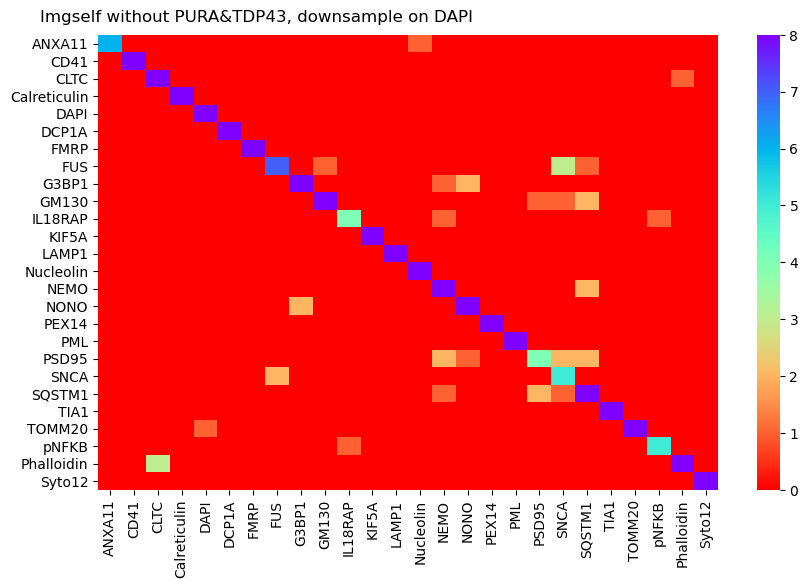

In [30]:
pred1_imgself_down, pred2_imgself_down, labels_true_imgself_down = predict(analytics_imgself_down,
                                                                           labels_unique_imgself_down,model_fc_imgself_down)
conf_imgself_down = metrics.confusion_matrix(labels_true_imgself_down,pred2_imgself_down,labels=labels_unique_imgself_down)
standard_labels_imgself_down = np.array(["ANXA11","CD41","CLTC","Calreticulin","DAPI","DCP1A","FMRP",
                                    "FUS","G3BP1","GM130","IL18RAP","KIF5A","LAMP1","Nucleolin",
                                    "NEMO","NONO","PEX14","PML","PSD95","SNCA","SQSTM1",
                                    "TIA1","TOMM20","pNFKB","Phalloidin","Syto12"])
conf_imgself_down = pd.DataFrame(conf_imgself_down, columns=standard_labels_imgself_down, index=standard_labels_imgself_down)
fig_imgself_down = plt.figure(figsize=(10,5))
sns.heatmap(conf_imgself_down,vmax=8,vmin=0,xticklabels=True,yticklabels=True,cmap='rainbow_r')
fig_imgself_down.suptitle("Imgself without PURA&TDP43, downsample on DAPI",ha='right')
fig_imgself_down.subplots_adjust(top=0.93, bottom=0.02)

In [62]:
res_imgself_down=show_scores(labels_true_imgself_down, pred1_imgself_down, pred2_imgself_down, labels_unique_imgself_down)
res_imgself_down.loc[res_imgself_down['label']=='syto12','label']='Syto12'
res_imgself_down.loc[res_imgself_down['label']=='NCL','label']='Nucleolin'
res_imgself_down.loc[res_imgself_down['label']=='SCNA','label']='SNCA'
res_imgself_down.loc[res_imgself_down['label']=='phalloidin','label']='Phalloidin'


res_imgself_down.to_csv("Imgself_Down_pretext_scores.csv",index=False)
res_imgself_down

,label,support,precision_1,recall_1,f_score_1,precision_2,recall_2,f_score_2
11,KIF5A,15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
21,TIA1,15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25,Syto12,14,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,CD41,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Calreticulin,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,FMRP,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
12,LAMP1,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,DCP1A,11,0.916667,1.000000,0.956522,1.000000,1.000000,1.000000
16,PEX14,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
17,PML,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:title={'center':'Test classification diff (downsample-imgself)'}, xlabel='label'>

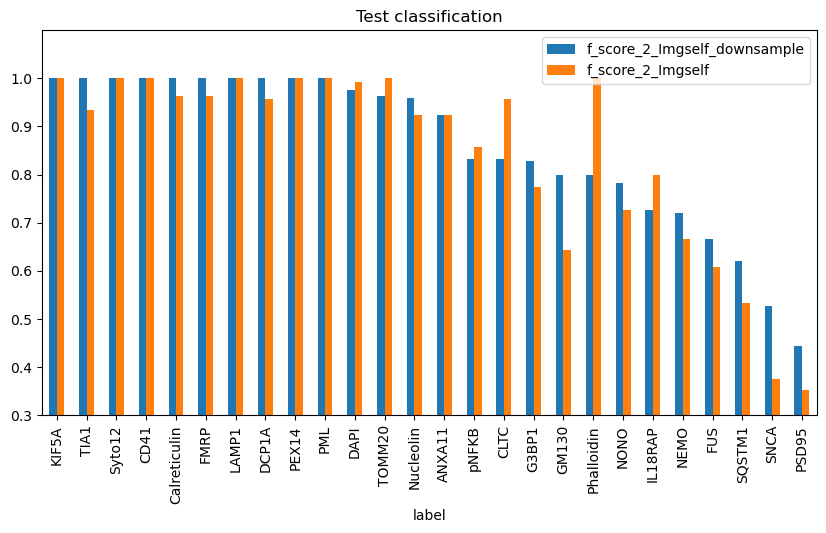

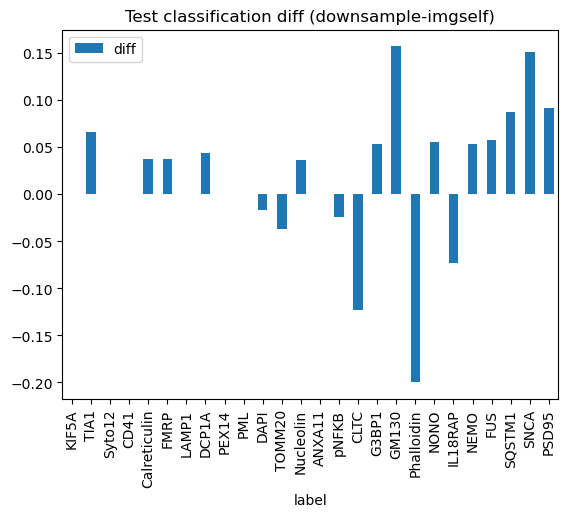

In [67]:
merged = res_imgself_down[['label','f_score_2']].merge(res_imgself[['label','f_score_2']],on='label',suffixes=['_Imgself_downsample','_Imgself'])
merged['diff'] = merged['f_score_2_Imgself_downsample'] - merged['f_score_2_Imgself']

merged.plot(x='label',y=['f_score_2_Imgself_downsample','f_score_2_Imgself'],
        kind='bar',
        stacked=False,
        title='Test classification', ylim=(0.3,1.1),yticks=np.arange(0.3,1.1,0.1),
           figsize=(10,5))

merged.plot(x='label',y='diff',
        kind='bar',
        stacked=False,
        title='Test classification diff (downsample-imgself)')

## Combined model with DAPI downsampled + without PURA, TDP43 + train 60%

In [9]:
images_combined_down, labels_combined_down, _, _ = load_data(input_folders_combined, condition_l=False, type_l=False,
                                                             cell_type_l=True,
                                                             cell_lines_include=["WT"],
                                                             split_by_set=False,
                                                             set_type="test",
                                                             markers=markers_for_load_comb,
                                                             conds_include=['unstressed'], verbose=False,
                                                            markers_for_downsample={"DAPI":0.12})

labels_unique_combined_down = np.unique(images_combined_down)

(8524, 100, 100, 2) (8524, 1)


In [13]:
analytics_combined_down = get_analytics(images_combined_down,labels_combined_down, 
                                       model_path="./model_outputs/comb_model_trying/model_ep0031_DAPI_down_train_60.h5")


X, y:
(8524, 100, 100, 2) (8524,)
Phalloidin_neurons        391
Nucleolin_neurons         317
FUS_neurons               317
DAPI_neurons              305
GM130_neurons             293
PML_neurons               254
PEX14_neurons             254
NONO_neurons              250
CD41_neurons              250
G3BP1_neurons             230
TIA1_neurons              230
KIF5A_neurons             230
LAMP1_neurons             229
Calreticulin_neurons      229
SNCA_neurons              222
CLTC_neurons              222
ANXA11_neurons            222
PSD95_neurons             222
DCP1A_neurons             207
NEMO_neurons              207
SQSTM1_neurons            189
FMRP_neurons              189
TOMM20_neurons            169
KIF5A_microglia           164
TIA1_microglia            164
G3BP1_microglia           164
DAPI_microglia            155
GM130_microglia           153
TOMM20_microglia          153
LAMP1_microglia           136
Calreticulin_microglia    136
CD41_microglia            135
FMRP_m

2023-01-02 17:45:22.528287: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/share/lsf/10.1/linux3.10-glibc2.17-x86_64/lib
2023-01-02 17:45:22.528327: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-02 17:45:22.528356: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (access.wexac.weizmann.ac.il): /proc/driver/nvidia/version does not exist
2023-01-02 17:45:22.529202: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2023-01-02 17:45:22.539402: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2023-01-02 17:45:22.541383: I tensorflow/compiler/xla

./model_outputs/comb_model_trying/model_ep0031_DAPI_down_train_60.h5
is loaded.
Ground truth:
['ANXA11_microglia' 'ANXA11_neurons' 'CD41_microglia' 'CD41_neurons'
 'CLTC_microglia' 'CLTC_neurons' 'Calreticulin_microglia'
 'Calreticulin_neurons' 'DAPI_microglia' 'DAPI_neurons' 'DCP1A_microglia'
 'DCP1A_neurons' 'FMRP_microglia' 'FMRP_neurons' 'FUS_microglia'
 'FUS_neurons' 'G3BP1_microglia' 'G3BP1_neurons' 'GM130_microglia'
 'GM130_neurons' 'KIF5A_microglia' 'KIF5A_neurons' 'LAMP1_microglia'
 'LAMP1_neurons' 'NCL_microglia' 'NEMO_microglia' 'NEMO_neurons'
 'NONO_microglia' 'NONO_neurons' 'Nucleolin_neurons' 'PEX14_microglia'
 'PEX14_neurons' 'PML_microglia' 'PML_neurons' 'PSD95_microglia'
 'PSD95_neurons' 'Phalloidin_neurons' 'SCNA_microglia' 'SNCA_neurons'
 'SQSTM1_microglia' 'SQSTM1_neurons' 'TIA1_microglia' 'TIA1_neurons'
 'TOMM20_microglia' 'TOMM20_neurons' 'phalloidin_microglia']


In [14]:
model_fc_combined_down = Model(analytics_combined_down.model.img_input, analytics_combined_down.model.fc_outputs[::-1])

In [18]:
pred1_combined_down, pred2_combined_down, labels_true_combined_down = predict(analytics_combined_down,
                                                                           labels_unique_combined_down,model_fc_combined_down)
conf_combined_down = metrics.confusion_matrix(labels_true_combined_down,pred2_combined_down,labels=labels_unique_combined_down)
standard_labels_combined_down = ['ANXA11_microglia', 'ANXA11_neurons', 'CD41_microglia','CD41_neurons',
                            'CLTC_microglia', 'CLTC_neurons','Calreticulin_microglia', 'Calreticulin_neurons',
                            'DAPI_microglia','DAPI_neurons', 'DCP1A_microglia', 'DCP1A_neurons',
                            'FMRP_microglia', 'FMRP_neurons', 'FUS_microglia', 'FUS_neurons',
                            'G3BP1_microglia', 'G3BP1_neurons', 'GM130_microglia','GM130_neurons',
                            'KIF5A_microglia', 'KIF5A_neurons','LAMP1_microglia', 'LAMP1_neurons',
                            'Nucleolin_microglia',
                            'NEMO_microglia', 'NEMO_neurons', 'NONO_microglia', 'NONO_neurons',
                            'Nucleolin_neurons',
                            'PEX14_microglia', 'PEX14_neurons','PML_microglia', 'PML_neurons',
                            'PSD95_microglia', 'PSD95_neurons',
                            'Phalloidin_neurons',
                            'SNCA_microglia', 'SNCA_neurons','SQSTM1_microglia', 'SQSTM1_neurons',
                            'TIA1_microglia','TIA1_neurons', 'TOMM20_microglia', 'TOMM20_neurons',
                            'Phalloidin_microglia']
conf_combined_down = pd.DataFrame(conf_combined_down, columns=standard_labels_combined_down, index=standard_labels_combined_down)
fig_combined_down = plt.figure(figsize=(10,5))
sns.heatmap(conf_combined_down,vmax=8,vmin=0,xticklabels=True,yticklabels=True,cmap='rainbow_r')
fig_combined_down.suptitle("Combined without 60% train, downsample on DAPI",ha='right')
fig_combined_down.subplots_adjust(top=0.93, bottom=0.02)

2023-01-02 17:48:43 INFO Predict...


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:
res_combined_down=show_scores(labels_true_imgself_down, pred1_imgself_down, pred2_imgself_down, labels_unique_imgself_down)
res_combined_down.loc[res_combined_down['label']=='syto12','label']='Syto12'
res_combined_down.loc[res_combined_down['label']=='NCL','label']='Nucleolin'
res_combined_down.loc[res_combined_down['label']=='SCNA','label']='SNCA'
res_combined_down.loc[res_combined_down['label']=='phalloidin','label']='Phalloidin'


res_imgself_down.to_csv("Imgself_Down_pretext_scores.csv",index=False)
res_imgself_down

In [ ]:
merged = res_imgself_down[['label','f_score_2']].merge(res_imgself[['label','f_score_2']],on='label',suffixes=['_Imgself_downsample','_Imgself'])
merged['diff'] = merged['f_score_2_Imgself_downsample'] - merged['f_score_2_Imgself']

merged.plot(x='label',y=['f_score_2_Imgself_downsample','f_score_2_Imgself'],
        kind='bar',
        stacked=False,
        title='Test classification', ylim=(0.3,1.1),yticks=np.arange(0.3,1.1,0.1),
           figsize=(10,5))

merged.plot(x='label',y='diff',
        kind='bar',
        stacked=False,
        title='Test classification diff (downsample-imgself)')